100%|██████████| 170M/170M [00:02<00:00, 80.7MB/s] 


Training CNN with SGD...
Done SGD in 131.5s. Final Loss: 1.2469
Training CNN with Momentum...
Done Momentum in 131.5s. Final Loss: 0.5041
Training CNN with Adam...
Done Adam in 130.9s. Final Loss: 0.5004


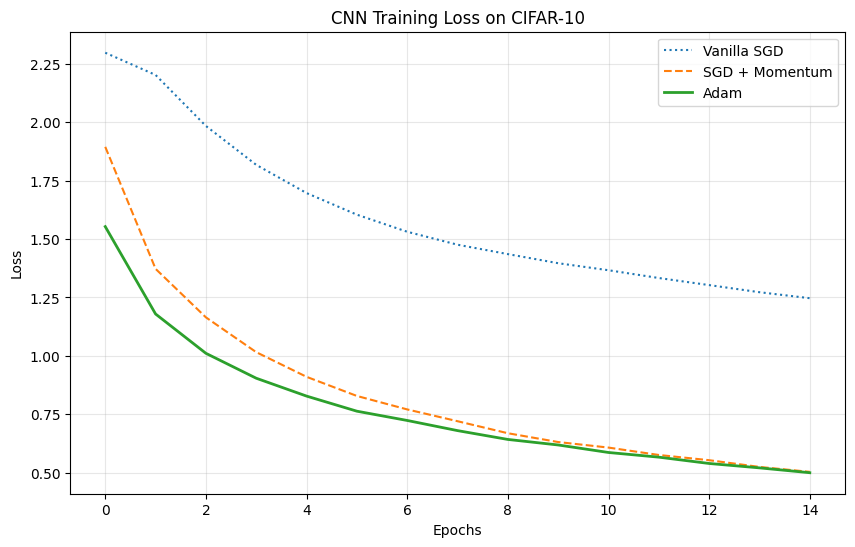

In [1]:
# ======================================================================================
# EXTENSION EXPERIMENT 2: CNN on CIFAR-10
# ======================================================================================
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Data CIFAR-10
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # Data Augmentation nhẹ
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# 2. Define Simple CNN Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 3. Training Loop
def train_cnn(opt_name, epochs=15):
    model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    
    if opt_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01) # Vanilla SGD
    elif opt_name == 'Momentum':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    elif opt_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
    losses = []
    print(f"Training CNN with {opt_name}...")
    st = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(trainloader)
        losses.append(avg_loss)
        
    print(f"Done {opt_name} in {time.time()-st:.1f}s. Final Loss: {losses[-1]:.4f}")
    return losses

# 4. Run & Compare
loss_sgd = train_cnn('SGD')
loss_mom = train_cnn('Momentum')
loss_adam = train_cnn('Adam')

# 5. Plot
plt.figure(figsize=(10, 6))
plt.plot(loss_sgd, label='Vanilla SGD', linestyle=':')
plt.plot(loss_mom, label='SGD + Momentum', linestyle='--')
plt.plot(loss_adam, label='Adam', linewidth=2)
plt.title("CNN Training Loss on CIFAR-10")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('cifar10_comparison.png', dpi=300)
plt.show()